# Green Tensor of a Cavity

We analyze the Green tensor of a cavity, which gives insight into when a cavity does change the interactions between two atoms.


In [1]:
# Uncomment the next line if you have ipympl installed and want interactive plots
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction as pi
from pairinteraction.green_tensor import GreenTensorCavity

In [2]:
n = 30
kets = {
    "nS": pi.KetAtom("Rb", n=n, l=0, j=0.5, m=0.5),
    "nP": pi.KetAtom("Rb", n=n, l=1, j=1.5, m=1.5),
    "nC": pi.KetAtom("Sr88_singlet", n=n, l=n - 1, m=n - 1),
    "(n+1)C": pi.KetAtom("Sr88_singlet", n=n + 1, l=n, m=n),
}

transition_energies: dict[str, float] = {}

for ket1, ket2 in [("nS", "nP"), ("nC", "(n+1)C")]:
    print(f"{ket1}: {kets[ket1]} - {ket2}: {kets[ket2]}")
    c3 = pi.C3(kets["nS"], kets["nP"]).get().to("planck_constant GHz mum^3")
    lifetimes = {ket_name: kets[ket_name].get_lifetime().to("ms") for ket_name in [ket1, ket2]}
    print(f"  c3={c3}")
    print(f"  lifetimes={lifetimes}")

    transition_energy = abs(kets[ket1].get_energy() - kets[ket2].get_energy())
    wavelength = transition_energy.to("micrometer", "spectroscopy")
    print(f"  transition_energy={transition_energy.to('planck_constant GHz')}")
    print(f"  wavelength={wavelength.to('micrometer')}")


transition_energy = abs(kets["(n+1)C"].get_energy() - kets["nC"].get_energy())
wavelength = transition_energy.to("micrometer", "spectroscopy")
wavelength_mum = wavelength.to("micrometer").m

The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.


nS: |Rb:30,S_1/2,1/2⟩ - nP: |Rb:30,P_3/2,3/2⟩


The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.
The single-channel quantum defect theory can be inaccurate for effective principal quantum numbers < 25. This can lead to inaccurate matrix elements.


  c3=0.2276675012895649 gigahertz * micrometer ** 3 * planck_constant
  lifetimes={'nS': <Quantity(0.0248593964, 'millisecond')>, 'nP': <Quantity(0.0501083257, 'millisecond')>}
  transition_energy=161.56862140797995 gigahertz * planck_constant
  wavelength=1855.5116419727844 micrometer
nC: |Sr88_singlet:30,29_29,29⟩ - (n+1)C: |Sr88_singlet:31,30_30,30⟩
  c3=0.2276675012895649 gigahertz * micrometer ** 3 * planck_constant
  lifetimes={'nC': <Quantity(2.19360709, 'millisecond')>, '(n+1)C': <Quantity(2.58725834, 'millisecond')>}
  transition_energy=232.02579196980213 gigahertz * planck_constant
  wavelength=1292.0652288475658 micrometer


In [3]:
from pairinteraction.green_tensor.green_tensor_free_space import GreenTensorFreeSpace

z_list = [
    min(10, 0.001 * wavelength_mum),
    min(500, 0.05 * wavelength_mum),
    0.2 * wavelength_mum,
    0.44 * wavelength_mum,
    0.5 * wavelength_mum,
    1 * wavelength_mum,
    2 * wavelength_mum,
    4 * wavelength_mum,
    np.inf,
]  # mum

V_dict = {}
distance_dict = {}
for i, z in enumerate(z_list):
    print(f"Calculating z {i + 1}/{len(z_list)}", 50 * " ")
    if np.isinf(z):
        distance_dict[z] = np.logspace(
            np.log10(0.01 * wavelength_mum), np.log10(50 * wavelength_mum), num=500
        )
    else:
        distance_dict[z] = np.logspace(np.log10(0.1 * z), np.log10(50 * z), num=20)

    tensor_list = []
    for j, d in enumerate(distance_dict[z]):
        print(f"  Calculating distance {j + 1}/{len(distance_dict[z])}: {d} mum", end="\r")
        if np.isinf(z):
            gt = GreenTensorFreeSpace([0, 0, 0], [d, 0, 0], unit="mum")
        else:
            gt = GreenTensorCavity([0, 0, 0], [d, 0, 0], z1=z / 2, z2=-z / 2, unit="mum")
            gt.set_relative_permittivities(1, 1e9, 1e9)  # almost perfect mirrors
        tensor = gt.get(1, 1, transition_energy)
        tensor_list.append(tensor)

    V_dict[z] = np.array([np.abs(np.real(tensor[0, 0].m)) for tensor in tensor_list])

Calculating z 1/9                                                   
Calculating z 2/9                                                   
Calculating z 3/9                                                   


/itp3/home/moegerle/Desktop/PairInteraction/pairinteraction_green_tensor/src/pairinteraction/green_tensor/utils.py:426: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  real_ellipse, _ = quad(integrand_ellipse, np.pi, 0, args=(*args, "real"), epsrel=1e-9, limit=1000)  # type: ignore [arg-type]


Calculating z 4/9                                                   


/itp3/home/moegerle/Desktop/PairInteraction/pairinteraction_green_tensor/src/pairinteraction/green_tensor/utils.py:426: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  real_ellipse, _ = quad(integrand_ellipse, np.pi, 0, args=(*args, "real"), epsrel=1e-9, limit=1000)  # type: ignore [arg-type]


Calculating z 5/9                                                   
Calculating z 6/9                                                   
Calculating z 7/9                                                   
Calculating z 8/9                                                   
Calculating z 9/9                                                   


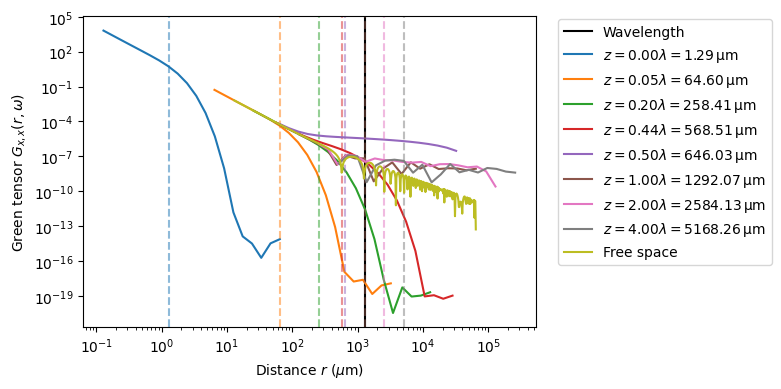

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.axvline(wavelength_mum, color="k", ls="-", label="Wavelength")

for i, (z, V) in enumerate(V_dict.items()):
    color = f"C{i}"
    label = rf"$z = {z / wavelength_mum:.2f} \lambda = {z:.2f} \, \mathrm{{\mu m}}$"
    if np.isinf(z):
        label = r"Free space"

    distance_list = distance_dict[z]
    ax.plot(
        distance_list,
        np.real(V),
        color=color,
        label=label,
    )

    ax.axvline(z, color=color, ls="dashed", alpha=0.5)


ax.set_ylabel(r"Green tensor $G_{x,x}(r, \omega)$")
ax.set_xlabel(r"Distance $r$ ($\mu$m)")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc=(1.05, 0.2))
fig.tight_layout()

plt.show()

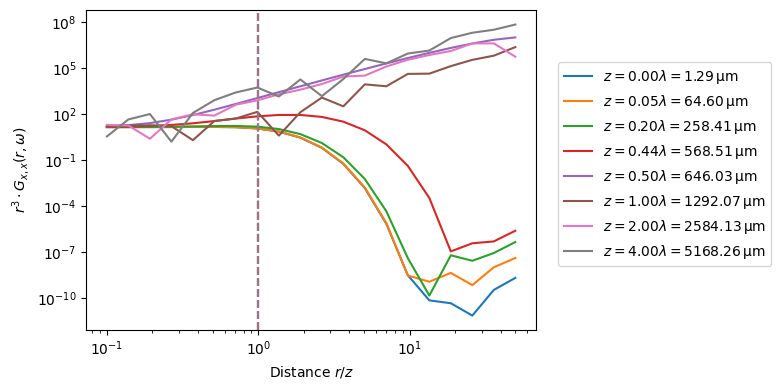

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, (z, V) in enumerate(V_dict.items()):
    color = f"C{i}"
    label = rf"$z = {z / wavelength_mum:.2f} \lambda = {z:.2f} \, \mathrm{{\mu m}}$"
    if np.isinf(z):
        continue

    distance_list = distance_dict[z]
    ax.plot(
        distance_list / z,
        np.real(V) * distance_list**3,
        color=color,
        label=label,
    )

    ax.axvline(z / z, color=color, ls="dashed", alpha=0.5)


ax.set_ylabel(r"$r^3 \cdot G_{x,x}(r, \omega)$")
ax.set_xlabel(r"Distance $r / z$")

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc=(1.05, 0.2))
fig.tight_layout()

plt.show()